In [1]:
#try:
    # Check if notebook is running in Google Colab
#import google.colab
    # Get additional files from Github
#    !wget https://raw.githubusercontent.com/volkerkrueger/edan95/master/labs/blackjack.py
#    !wget https://raw.githubusercontent.com/volkerkrueger/edan95/master/labs/plotting.py
    # Install additional dependencies
!pip install gym
#!apt-get install python-opengl -y
import gym
import matplotlib
import numpy as np
import sys
import time
from blackjack import BlackjackEnv
from collections import defaultdict
import plotting
matplotlib.style.use('ggplot')
  #  %matplotlib inline

#from collections import defaultdict

#from blackjack import BlackjackEnv

In [2]:
env = BlackjackEnv()
np.arange(2)

array([0, 1])

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    
    def policy_fn(observation):
        action_prob = np.ones(nA) * epsilon/nA 
        score, dealer_score, usable_ace = observation
        
        max_index = np.argmax(Q[observation])
        
        action_prob[max_index] = 1 - epsilon + epsilon/nA 
        return action_prob
        #alt calc MDP?

    

    
    
    return policy_fn

In [8]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros( env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # Implement this!
    
    for i_episode in range(1, num_episodes + 1):
        if i_episode % 10000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        
        if i_episode in [10000, 50000, 100000, 300000, 400000, 500000]:
            rewards = [[],[]]
            for i in range(300):
                state = env.reset()
                for t in range(100):
                    probs = policy(state)
                    action = np.random.choice(np.arange(2), p=probs)
                    next_state, reward, done, _ = env.step(action)
                    if done:
                        if state[2]:
                            rewards[0].append(reward)
                        else:
                            rewards[1].append(reward)
                        break
                    state = next_state
            V = defaultdict(float)
            for state, actions in Q.items():
                action_value = np.max(actions)
                V[state] = action_value
            plotting.plot_value_function(V, title= "{} episdoes".format(i_episode))
            print('\nEpsilon: ' + str(epsilon))
            print('No Usable Ace ---- ' + str(len(rewards[1])))
            print("mean: " + str(np.mean(rewards[1])))
            print("min: " + str(min(rewards[1])))
            print("max: " + str(max(rewards[1])))
            print("std: " + str(np.std(rewards[1])))
            print('Usable Ace ---- ' + str(len(rewards[0])))
            print("mean: " + str(np.mean(rewards[0])))
            print("min: " + str(min(rewards[0])))
            print("max: " + str(max(rewards[0])))
            print("std: " + str(np.std(rewards[0])))
            print(probs)
        
        episode = []
        state = env.reset()
        for t in range(100):
            probs = policy(state)
            action = np.random.choice(np.arange(2), p=probs)
            next_state, reward, done, _ = env.step(action)
            
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
            
        
        state_act_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in state_act_in_episode:
            
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state and x[1] == action)
            
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            
            # Calculate average return for this state over all sampled episodes
            #returns_sum[(state,action)] += G
            returns_count[(state,action)] += 1.0
            
            #mean of probabilities of that state? adjusted for reward? 
            Q[state][action] += (G-Q[state][action])/ returns_count[(state,action)]
            #Q[state] = returns_sum[state] / returns_count[state]
            
        
        epsilon = 500.0/(i_episode+500)
        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
        
    
    return Q, policy

C:\Users\thoma\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


Episode 10000/500000.

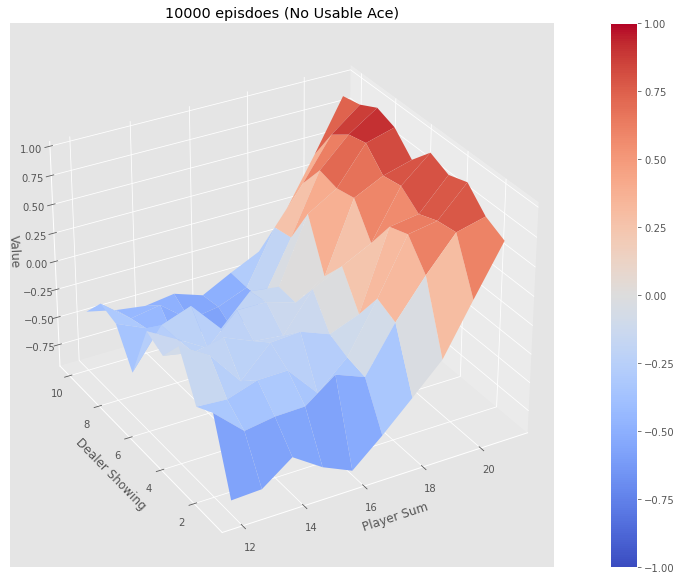

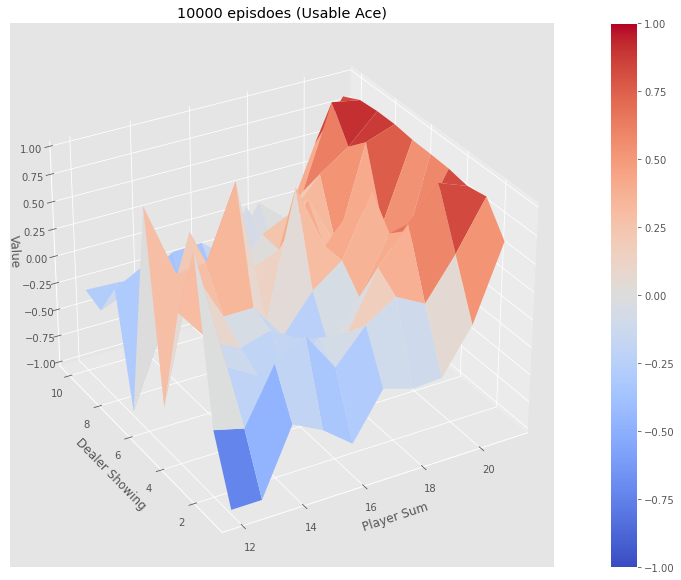


Epsilon: 0.04762358319839985
No Usable Ace ---- 262
mean: -0.03816793893129771
min: -1
max: 1
std: 0.9563334893168187
Usable Ace ---- 38
mean: 0.2631578947368421
min: -1
max: 1
std: 0.90856192113853
[0.02381179 0.97618821]
Episode 50000/500000.

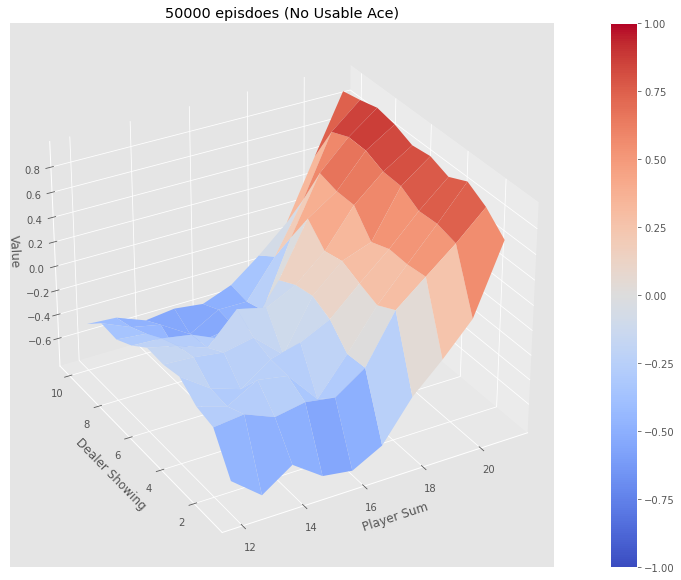

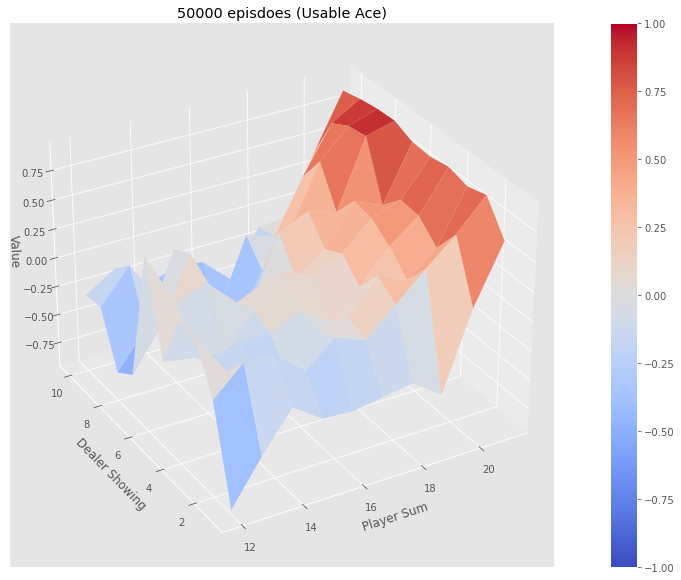


Epsilon: 0.00990118616210222
No Usable Ace ---- 268
mean: -0.12313432835820895
min: -1
max: 1
std: 0.9481650919841885
Usable Ace ---- 32
mean: 0.53125
min: -1
max: 1
std: 0.8285670989726782
[0.99504941 0.00495059]
Episode 100000/500000.

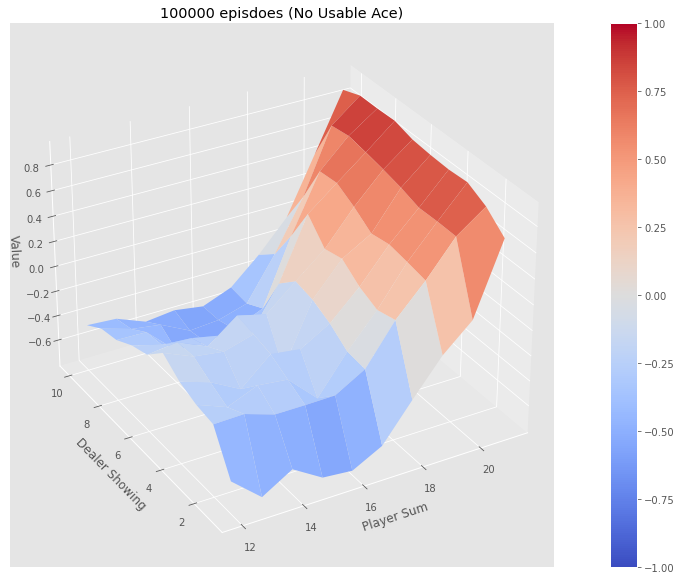

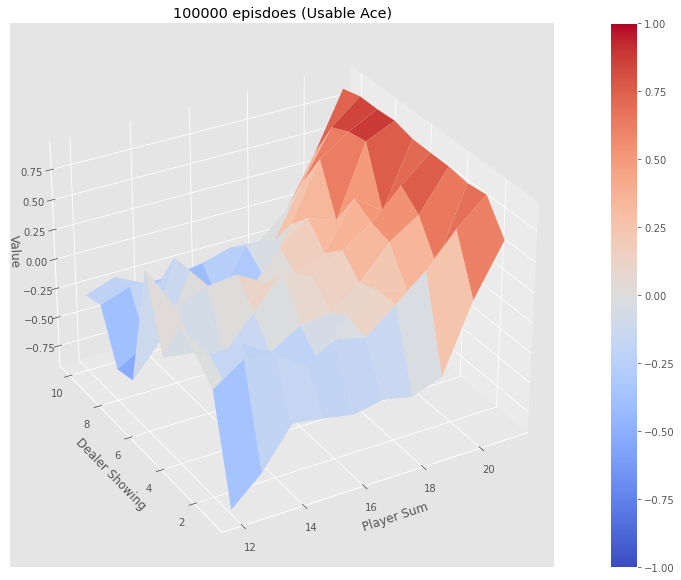


Epsilon: 0.004975173882327187
No Usable Ace ---- 265
mean: -0.18867924528301888
min: -1
max: 1
std: 0.9246438125761074
Usable Ace ---- 35
mean: 0.2857142857142857
min: -1
max: 1
std: 0.9124982527240749
[0.99751241 0.00248759]
Episode 300000/500000.

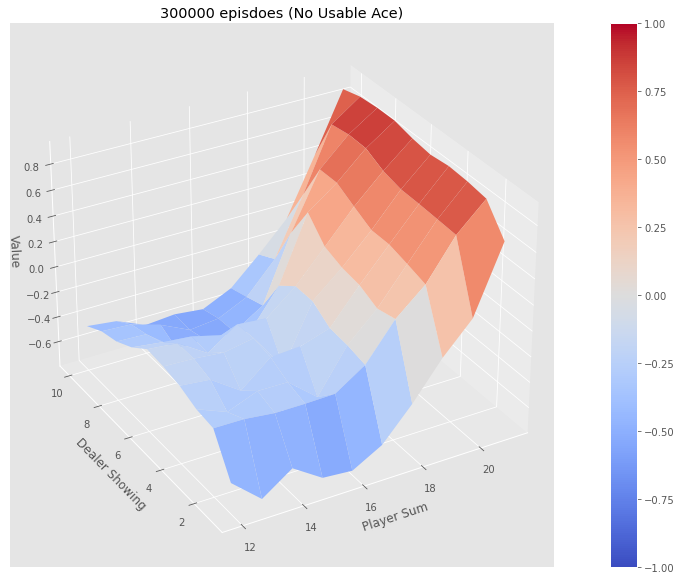

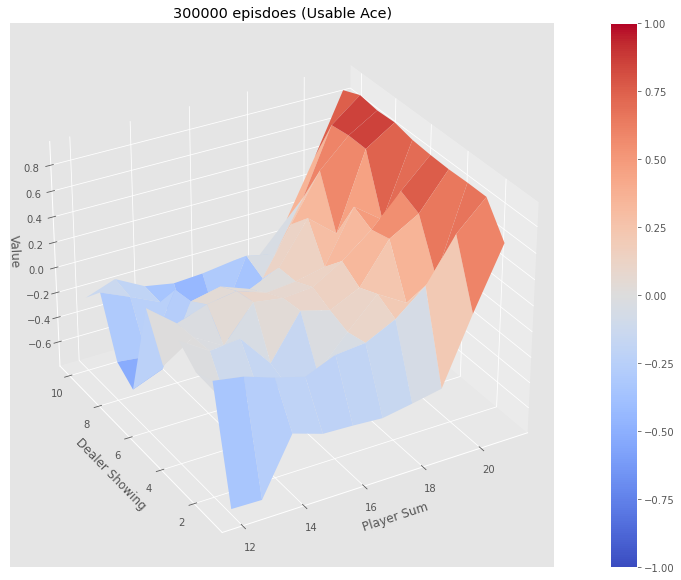


Epsilon: 0.0016638990479169648
No Usable Ace ---- 273
mean: -0.08424908424908426
min: -1
max: 1
std: 0.94745131619788
Usable Ace ---- 27
mean: 0.5925925925925926
min: -1
max: 1
std: 0.7332959212304937
[8.31949524e-04 9.99168050e-01]
Episode 400000/500000.

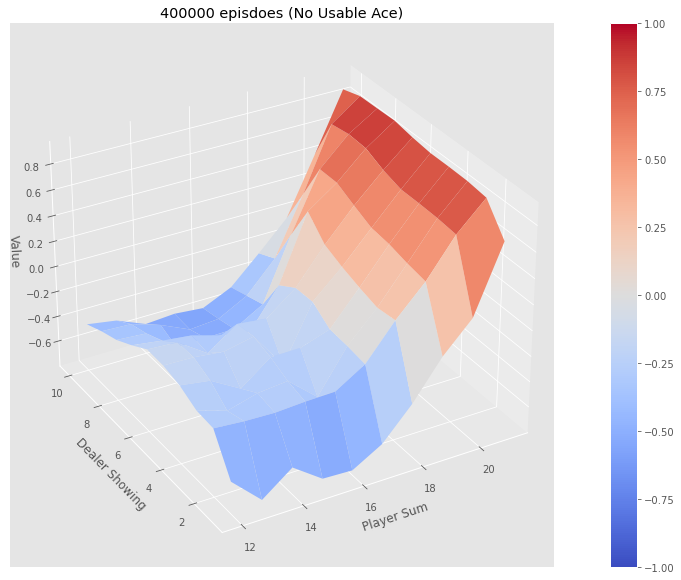

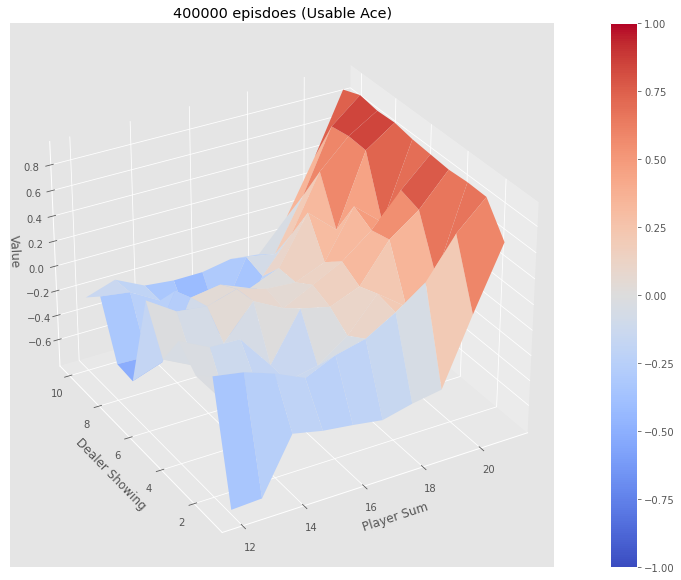


Epsilon: 0.001248442567896549
No Usable Ace ---- 255
mean: -0.15294117647058825
min: -1
max: 1
std: 0.9435753741677825
Usable Ace ---- 45
mean: 0.5777777777777777
min: -1
max: 1
std: 0.7742778395637486
[9.99375779e-01 6.24221284e-04]
Episode 500000/500000.

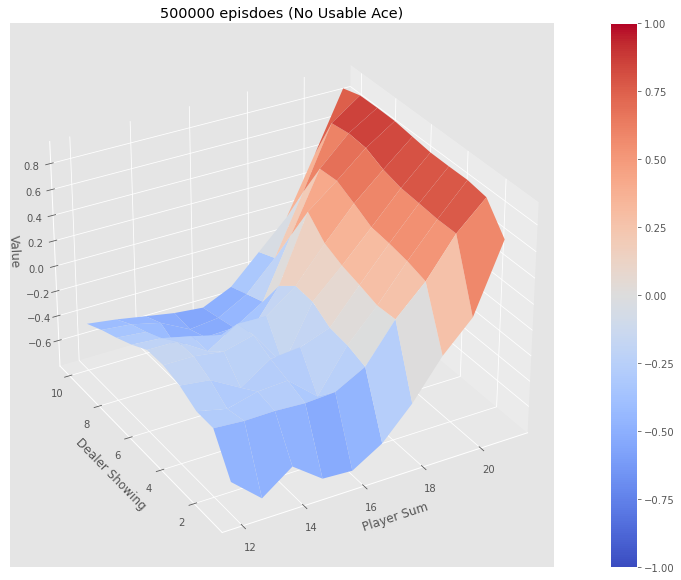

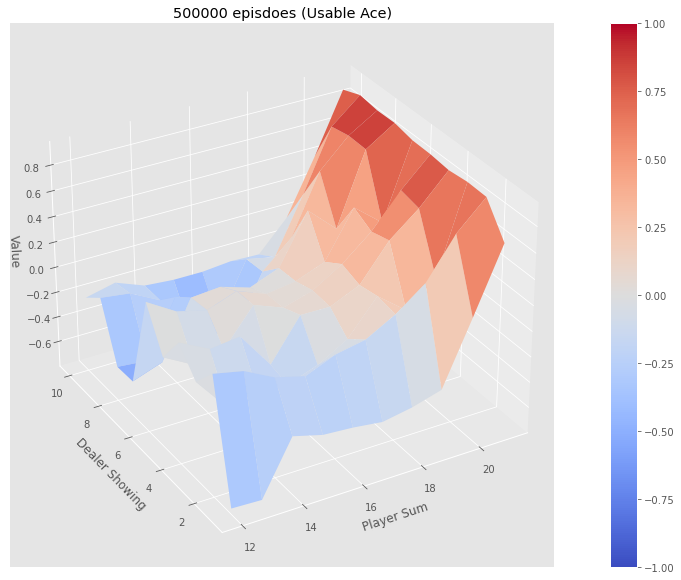


Epsilon: 0.0009990029950109791
No Usable Ace ---- 265
mean: -0.2792452830188679
min: -1
max: 1
std: 0.9180287516700358
Usable Ace ---- 35
mean: 0.6571428571428571
min: -1
max: 1
std: 0.6737043498600912
[9.99500499e-01 4.99501498e-04]

 94.61343069999998 s


C:\Users\thoma\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


In [9]:
start = time.clock()

Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

end = time.clock()
print("\n",end - start,"s")

